In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pyarrow
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, max_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint

In [232]:
data_path= f"/content/rate_of_sale_may_2023.snappy.parquet"
data_dict_path = f"/content/rate_of_sale_data_dict1.csv"
data_df = pd.read_parquet(data_path)
data_dict_df = pd.read_csv(data_dict_path)

In [233]:
data_df['zero_to_sixty_mph_seconds'] = pd.to_numeric(data_df['zero_to_sixty_mph_seconds'], errors='coerce')

data_df['zero_to_sixty_mph_seconds'] = pd.to_numeric(data_df['zero_to_sixty_mph_seconds'], errors='coerce')

mean_zero_to_sixty = data_df['zero_to_sixty_mph_seconds'].mean()
data_df['zero_to_sixty_mph_seconds'].fillna(mean_zero_to_sixty, inplace=True)

In [234]:
print(data_df['zero_to_sixty_mph_seconds'])

0          7.200000
1          9.659446
2         12.400000
3          9.659446
4          9.659446
            ...    
224550     9.659446
224551     9.659446
224552     9.659446
224553    10.700000
224554     8.900000
Name: zero_to_sixty_mph_seconds, Length: 224555, dtype: float64


In [235]:
mean_zero_to_sixty

9.659445966364874

,days_to_sell,first_retailer_asking_price,last_retailer_asking_price,odometer_reading_miles
count,224555.000000,2.245550e+05,2.236260e+05,2.245550e+05
mean,44.423771,1.871680e+04,1.802800e+04,4.461378e+04
std,56.751408,4.190931e+04,2.067387e+04,3.305834e+04
min,0.000000,1.000000e+00,1.000000e+00,0.000000e+00
25%,12.000000,8.995000e+03,8.900000e+03,1.883000e+04
50%,28.000000,1.524900e+04,1.499100e+04,3.772400e+04
75%,56.000000,2.299000e+04,2.204875e+04,6.400000e+04
max,1829.000000,1.779950e+07,4.999995e+06,1.632147e+06


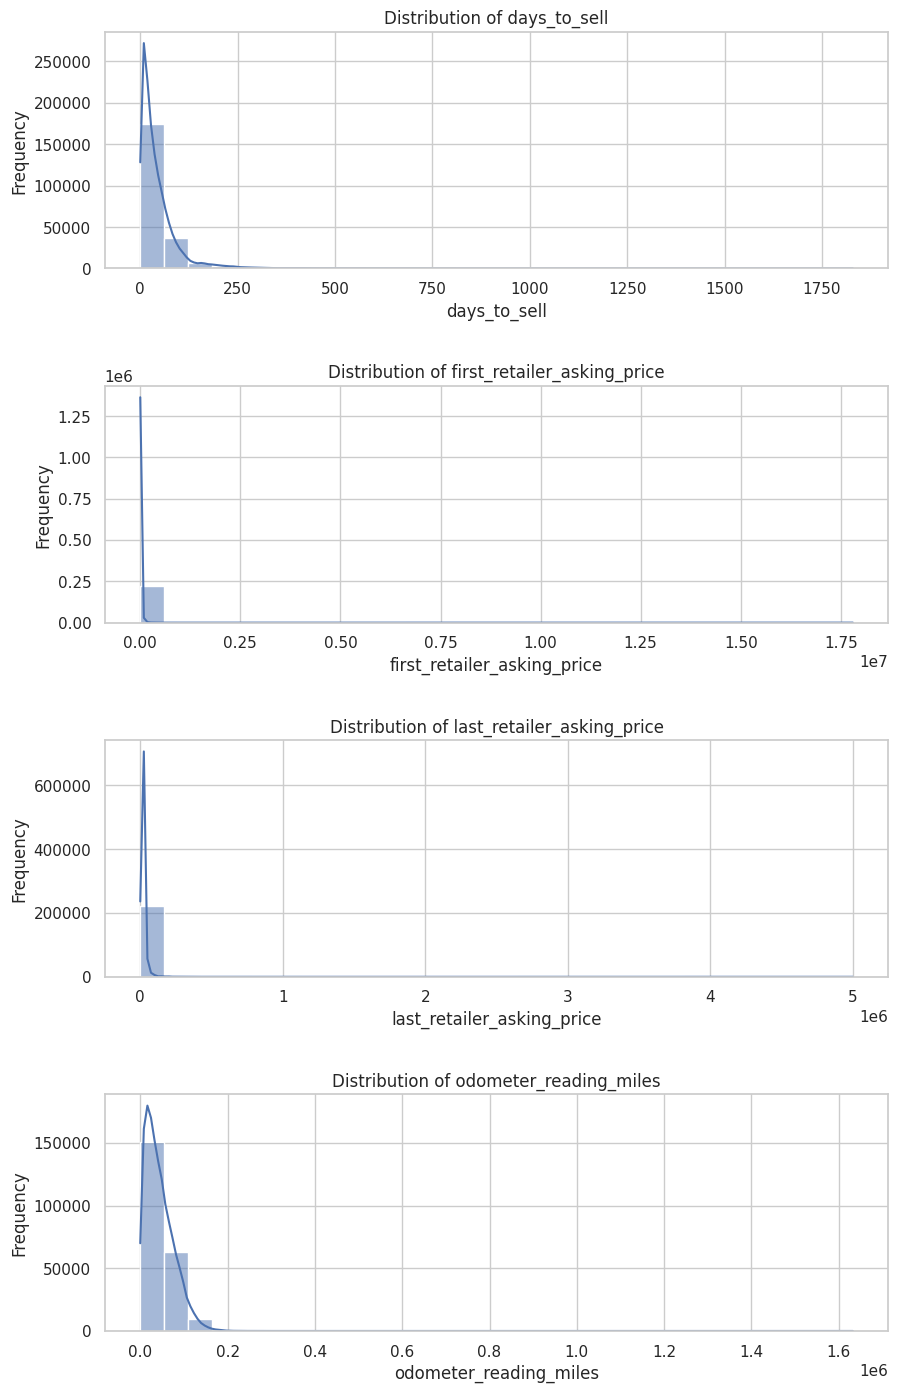

In [236]:
sns.set(style="whitegrid")

features_to_analyze = ['days_to_sell', 'first_retailer_asking_price', 'last_retailer_asking_price', 'odometer_reading_miles']

descriptive_stats = data_df[features_to_analyze].describe()

fig, axes = plt.subplots(len(features_to_analyze), 1, figsize=(10, 15))
fig.tight_layout(pad=5.0)

for i, feature in enumerate(features_to_analyze):
    sns.histplot(data_df[feature], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(f'{feature}')
    axes[i].set_ylabel('Frequency')

descriptive_stats

In [237]:
quantitative_features = data_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
qualitative_features = data_df.select_dtypes(include=['object']).columns.tolist()

quantitative_analysis = data_df[quantitative_features].describe()

quantitative_features, qualitative_features, quantitative_analysis

(['first_retailer_asking_price',
  'last_retailer_asking_price',
  'reviews_per_100_advertised_stock_last_12_months',
  'seats',
  'doors',
  'co2_emission_gpkm',
  'top_speed_mph',
  'zero_to_sixty_mph_seconds',
  'battery_range_miles',
  'boot_space_seats_up_litres',
  'odometer_reading_miles',
  'adjusted_retail_amount_gbp',
  'predicted_mileage',
  'advert_quality'],
 ['stock_item_id',
  'last_date_seen',
  'first_date_seen',
  'segment',
  'engine_power_bhp',
  'fuel_economy_wltp_combined_mpg',
  'battery_usable_capacity_kwh',
  'length_mm',
  'insurance_group',
  'plate',
  'make',
  'model',
  'generation',
  'derivative',
  'derivative_id',
  'body_type',
  'fuel_type',
  'transmission_type',
  'drivetrain',
  'colour',
  'first_registration_date',
  'attention_grabber',
  'price_indicator_rating',
  'postcode_area'],
        first_retailer_asking_price  last_retailer_asking_price  \
 count                 2.245550e+05                2.236260e+05   
 mean                  1.871

In [238]:

missing_data = data_df.isnull().sum()
missing_data_percentage = (data_df.isnull().sum() / len(data_df)) * 100
missing_data_summary = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_data_percentage})
missing_data_summary[missing_data_summary['Missing Values'] > 0]

,Missing Values,Percentage
last_retailer_asking_price,929,0.413707
reviews_per_100_advertised_stock_last_12_months,33266,14.814188
segment,32,0.014250
seats,129,0.057447
doors,4,0.001781
co2_emission_gpkm,117,0.052103
top_speed_mph,653,0.290797
engine_power_bhp,2,0.000891
fuel_economy_wltp_combined_mpg,6868,3.058493
battery_range_miles,213494,95.074258


In [ ]:
#color dummy data
#anything under a 10000 dropna
#electrical related = 0
#reviews_per_100_advertised_stock_last_12_months average
#zero_to_sixty_mph_seconds = average
#advert q = average
#attention_grabber	= average

In [239]:
data_cleaned = data_df.dropna(subset=['postcode_area','last_retailer_asking_price','segment','seats','doors','co2_emission_gpkm','top_speed_mph','engine_power_bhp','fuel_economy_wltp_combined_mpg','length_mm','boot_space_seats_up_litres','insurance_group','plate','drivetrain','colour','first_registration_date','adjusted_retail_amount_gbp','predicted_mileage'])

In [240]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202630 entries, 1 to 224554
Data columns (total 42 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   stock_item_id                                    202630 non-null  object 
 1   last_date_seen                                   202630 non-null  object 
 2   first_date_seen                                  202630 non-null  object 
 3   days_to_sell                                     202630 non-null  int32  
 4   first_retailer_asking_price                      202630 non-null  int64  
 5   last_retailer_asking_price                       202630 non-null  float64
 6   can_home_deliver                                 202630 non-null  bool   
 7   reviews_per_100_advertised_stock_last_12_months  172619 non-null  float64
 8   segment                                          202630 non-null  object 
 9   seats          

In [241]:
average = ['reviews_per_100_advertised_stock_last_12_months','advert_quality']
for columns in average:
    mean_value = data_cleaned[columns].mean()
    data_cleaned[columns].fillna(mean_value, inplace=True)


data_cleaned['zero_to_sixty_mph_seconds'].fillna(mean_zero_to_sixty, inplace=True)

zeros = ['battery_range_miles']
for column in zeros:
    data_cleaned[column].fillna(0, inplace=True)
na = ['battery_usable_capacity_kwh']
for column in na:
    data_cleaned[column].fillna('random', inplace = True)

In [242]:
missing_data = data_cleaned.isnull().sum()
missing_data_percentage = (data_cleaned.isnull().sum() / len(data_df)) * 100

missing_data_summary = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_data_percentage})
missing_data_summary[missing_data_summary['Missing Values'] > 0]

,Missing Values,Percentage
attention_grabber,17816,7.933914


In [243]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202630 entries, 1 to 224554
Data columns (total 42 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   stock_item_id                                    202630 non-null  object 
 1   last_date_seen                                   202630 non-null  object 
 2   first_date_seen                                  202630 non-null  object 
 3   days_to_sell                                     202630 non-null  int32  
 4   first_retailer_asking_price                      202630 non-null  int64  
 5   last_retailer_asking_price                       202630 non-null  float64
 6   can_home_deliver                                 202630 non-null  bool   
 7   reviews_per_100_advertised_stock_last_12_months  202630 non-null  float64
 8   segment                                          202630 non-null  object 
 9   seats          

In [ ]:
#stock_item_id
#boot_space_seats_up_litres
#length_mm
#plate
#derivative_id
#body_type
#attention_grabber

In [244]:
features_to_drop = ['fuel_economy_wltp_combined_mpg','last_date_seen','stock_item_id','boot_space_seats_up_litres','length_mm','plate','derivative_id','body_type','attention_grabber','seats','doors','predicted_mileage','postcode_area','co2_emission_gpkm','manufacturer_approved','reviews_per_100_advertised_stock_last_12_months','can_home_deliver']

In [245]:
reduced_df = data_cleaned.drop(features_to_drop, axis=1)

In [246]:
reduced_df.describe()

,days_to_sell,first_retailer_asking_price,last_retailer_asking_price,top_speed_mph,zero_to_sixty_mph_seconds,battery_range_miles,odometer_reading_miles,adjusted_retail_amount_gbp,number_of_images,advert_quality
count,202630.000000,202630.000000,2.026300e+05,202630.000000,202630.000000,202630.000000,202630.000000,202630.000000,202630.000000,202630.000000
mean,43.476884,18103.844835,1.765063e+04,123.772067,9.654610,1.146943,43726.888580,17800.777688,32.923688,54.656372
std,55.037267,14576.363898,1.768621e+04,16.661185,1.421638,12.118332,31280.468199,13629.490895,18.679374,13.569607
min,0.000000,1.000000,1.000000e+00,0.000000,2.400000,0.000000,0.000000,349.000000,0.000000,1.000000
25%,13.000000,9495.000000,9.295000e+03,112.000000,9.659446,0.000000,19188.250000,9417.000000,20.000000,49.000000
50%,28.000000,15200.000000,1.499500e+04,121.000000,9.659446,0.000000,37494.000000,15139.000000,31.000000,54.656372
75%,55.000000,22490.000000,2.199100e+04,134.000000,9.659446,0.000000,62508.250000,22104.000000,42.000000,63.000000
max,1829.000000,898100.000000,4.999995e+06,248.000000,24.000000,414.000000,901128.000000,233997.000000,199.000000,100.000000


In [247]:
qualitative_features = reduced_df.select_dtypes(include=['int','float']).columns.tolist()
qualitative_features

['days_to_sell',
 'first_retailer_asking_price',
 'last_retailer_asking_price',
 'top_speed_mph',
 'zero_to_sixty_mph_seconds',
 'battery_range_miles',
 'odometer_reading_miles',
 'adjusted_retail_amount_gbp',
 'number_of_images',
 'advert_quality']

In [248]:
cont_cols = ['first_retailer_asking_price',
 'last_retailer_asking_price',
 'top_speed_mph',
 'zero_to_sixty_mph_seconds',
 'battery_range_miles',
 'odometer_reading_miles',
 'adjusted_retail_amount_gbp']

In [249]:
for col in cont_cols:
    Q1 = reduced_df[col].quantile(0.25)
    Q3 = reduced_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    reduced_df[col] = np.where(reduced_df[col] > upper_bound, reduced_df[col].quantile(0.95), reduced_df[col])
    reduced_df[col] = np.where(reduced_df[col] < lower_bound, reduced_df[col].quantile(0.05), reduced_df[col])

<Axes: ylabel='advert_quality'>

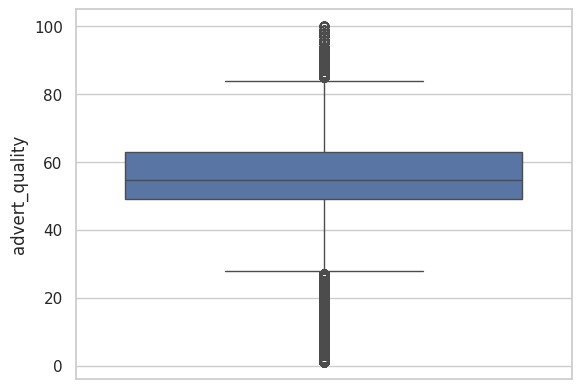

In [250]:
sns.boxplot(reduced_df["advert_quality"])

In [251]:
correlation_matrix = reduced_df.corr()

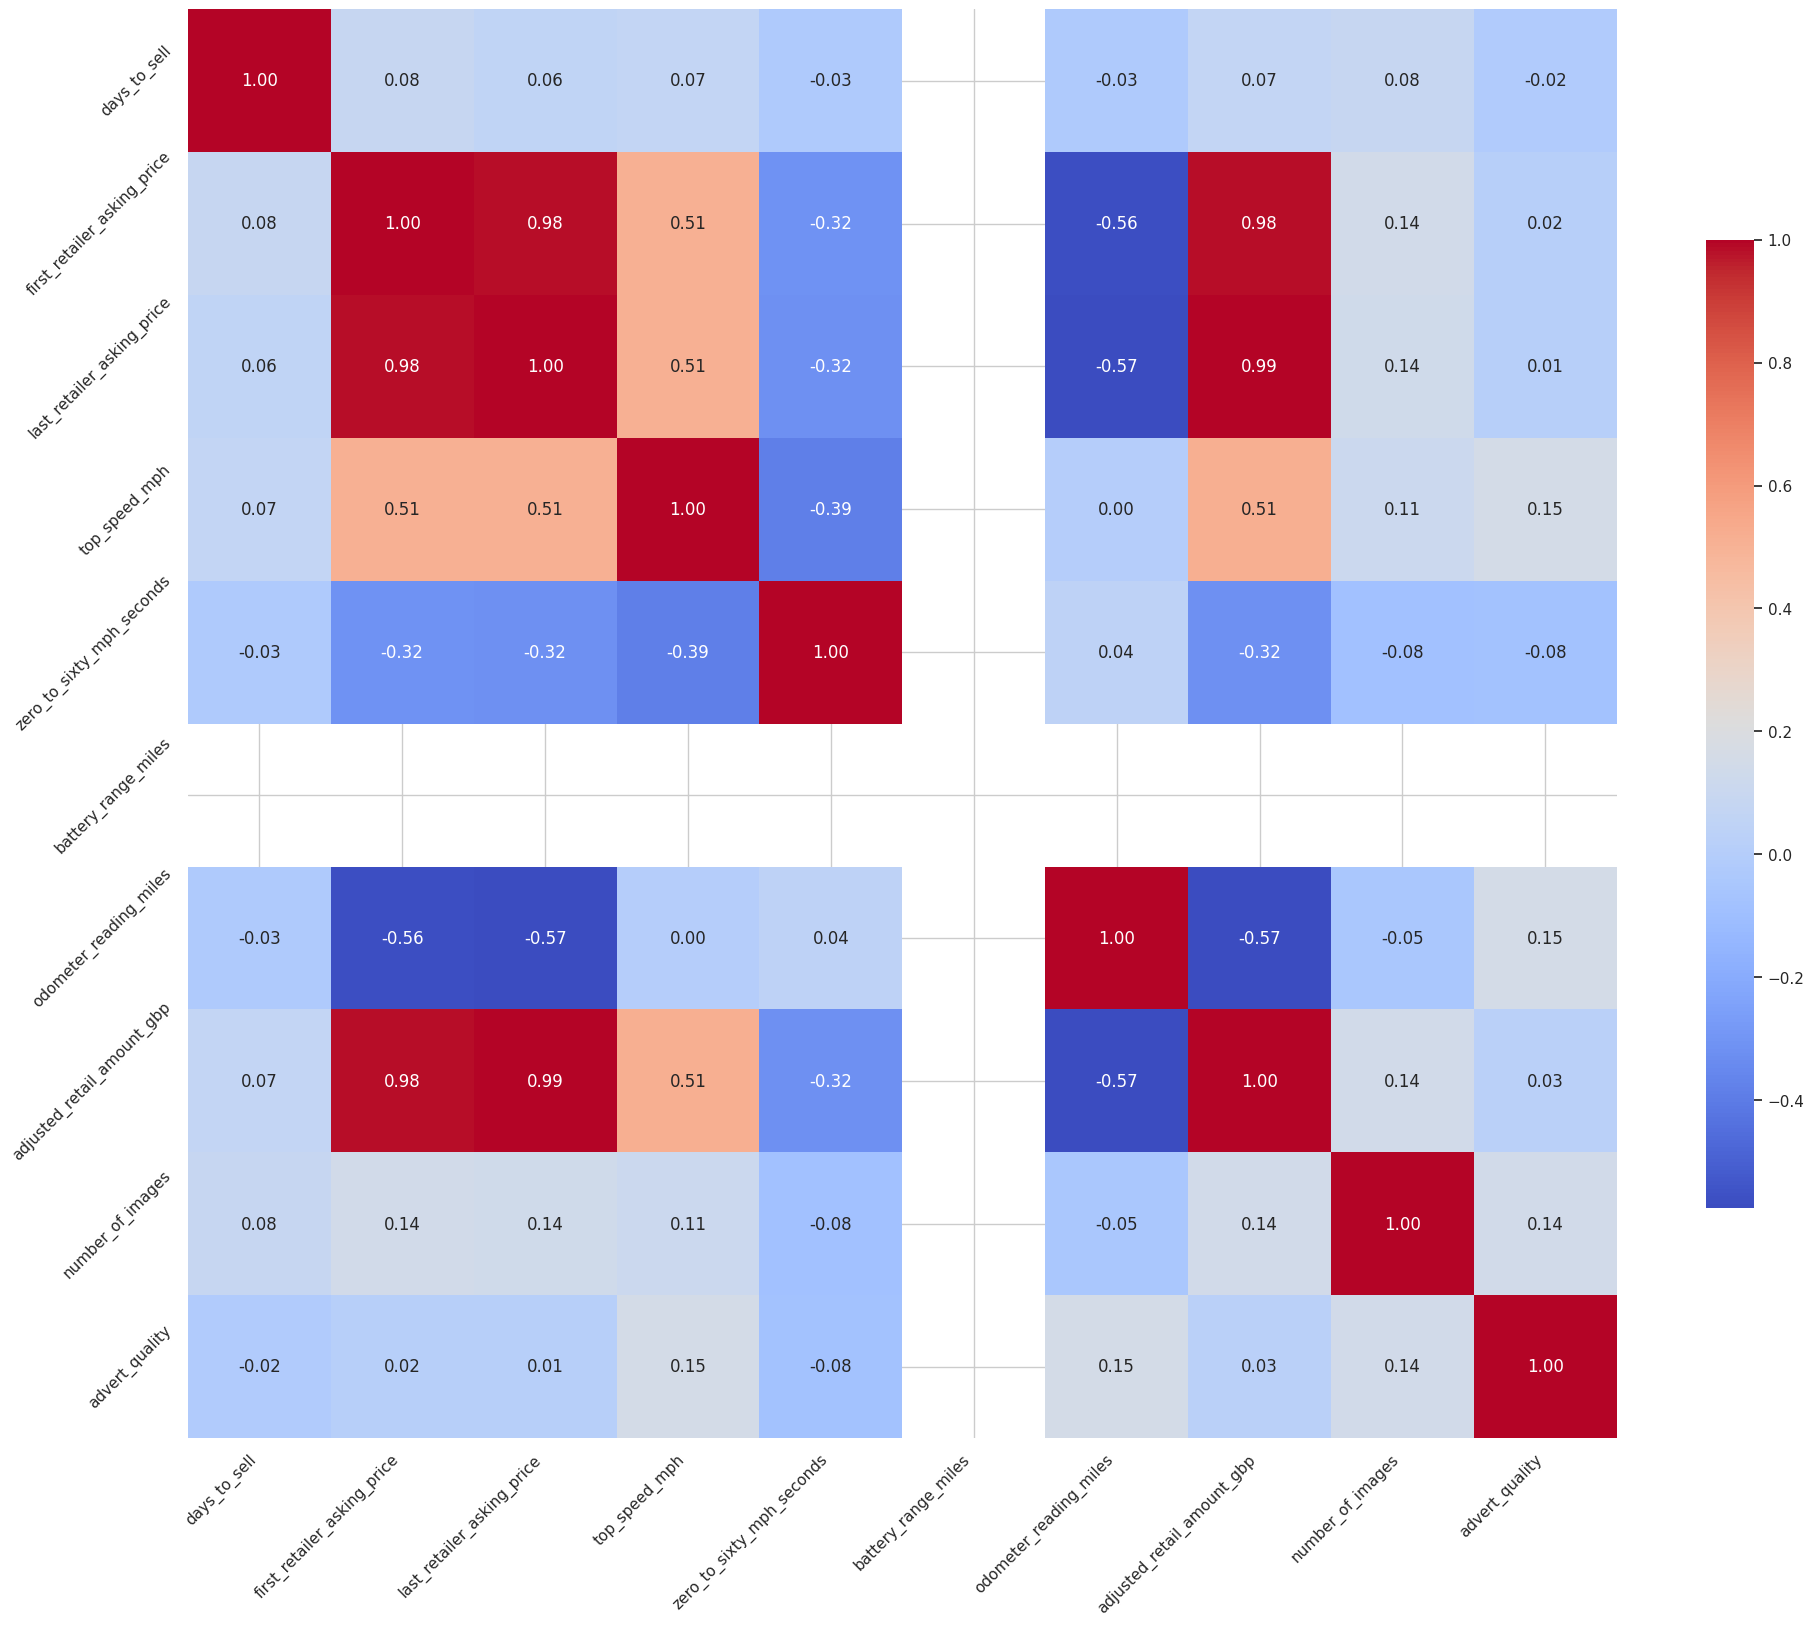

In [252]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = reduced_df.corr()

plt.figure(figsize=(20, 20))

# Generate a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [253]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202630 entries, 1 to 224554
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   first_date_seen              202630 non-null  object 
 1   days_to_sell                 202630 non-null  int32  
 2   first_retailer_asking_price  202630 non-null  float64
 3   last_retailer_asking_price   202630 non-null  float64
 4   segment                      202630 non-null  object 
 5   top_speed_mph                202630 non-null  float64
 6   zero_to_sixty_mph_seconds    202630 non-null  float64
 7   engine_power_bhp             202630 non-null  object 
 8   battery_range_miles          202630 non-null  float64
 9   battery_usable_capacity_kwh  202630 non-null  object 
 10  insurance_group              202630 non-null  object 
 11  make                         202630 non-null  object 
 12  model                        202630 non-null  object 
 13 

In [254]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [255]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202630 entries, 1 to 224554
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   first_date_seen              202630 non-null  object 
 1   days_to_sell                 202630 non-null  int32  
 2   first_retailer_asking_price  202630 non-null  float64
 3   last_retailer_asking_price   202630 non-null  float64
 4   segment                      202630 non-null  object 
 5   top_speed_mph                202630 non-null  float64
 6   zero_to_sixty_mph_seconds    202630 non-null  float64
 7   engine_power_bhp             202630 non-null  object 
 8   battery_range_miles          202630 non-null  float64
 9   battery_usable_capacity_kwh  202630 non-null  object 
 10  insurance_group              202630 non-null  object 
 11  make                         202630 non-null  object 
 12  model                        202630 non-null  object 
 13 

In [256]:
qualitative_features = reduced_df.select_dtypes(include=['object']).columns.tolist()
qualitative_features

['first_date_seen',
 'segment',
 'engine_power_bhp',
 'battery_usable_capacity_kwh',
 'insurance_group',
 'make',
 'model',
 'generation',
 'derivative',
 'fuel_type',
 'transmission_type',
 'drivetrain',
 'colour',
 'first_registration_date',
 'price_indicator_rating']

In [257]:

reduced_df['zero_to_sixty_mph_seconds'] = reduced_df['zero_to_sixty_mph_seconds'].astype(str)
reduced_df['zero_to_sixty_mph_seconds'] = pd.to_numeric(reduced_df['zero_to_sixty_mph_seconds'], errors='coerce')


In [258]:
df = reduced_df
discrete_cols = [
 'first_date_seen',
 'segment',
 'zero_to_sixty_mph_seconds',
 'engine_power_bhp',
 'battery_usable_capacity_kwh',
 'insurance_group',
 'make',
 'model',
 'generation',
 'derivative',
 'fuel_type',
 'transmission_type',
 'drivetrain',
 'colour',
 'first_registration_date',
 'price_indicator_rating']

label_encoder = LabelEncoder()
for col in discrete_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202630 entries, 1 to 224554
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   first_date_seen              202630 non-null  int64  
 1   days_to_sell                 202630 non-null  int32  
 2   first_retailer_asking_price  202630 non-null  float64
 3   last_retailer_asking_price   202630 non-null  float64
 4   segment                      202630 non-null  int64  
 5   top_speed_mph                202630 non-null  float64
 6   zero_to_sixty_mph_seconds    202630 non-null  int64  
 7   engine_power_bhp             202630 non-null  int64  
 8   battery_range_miles          202630 non-null  float64
 9   battery_usable_capacity_kwh  202630 non-null  int64  
 10  insurance_group              202630 non-null  int64  
 11  make                         202630 non-null  int64  
 12  model                        202630 non-null  int64  
 13 

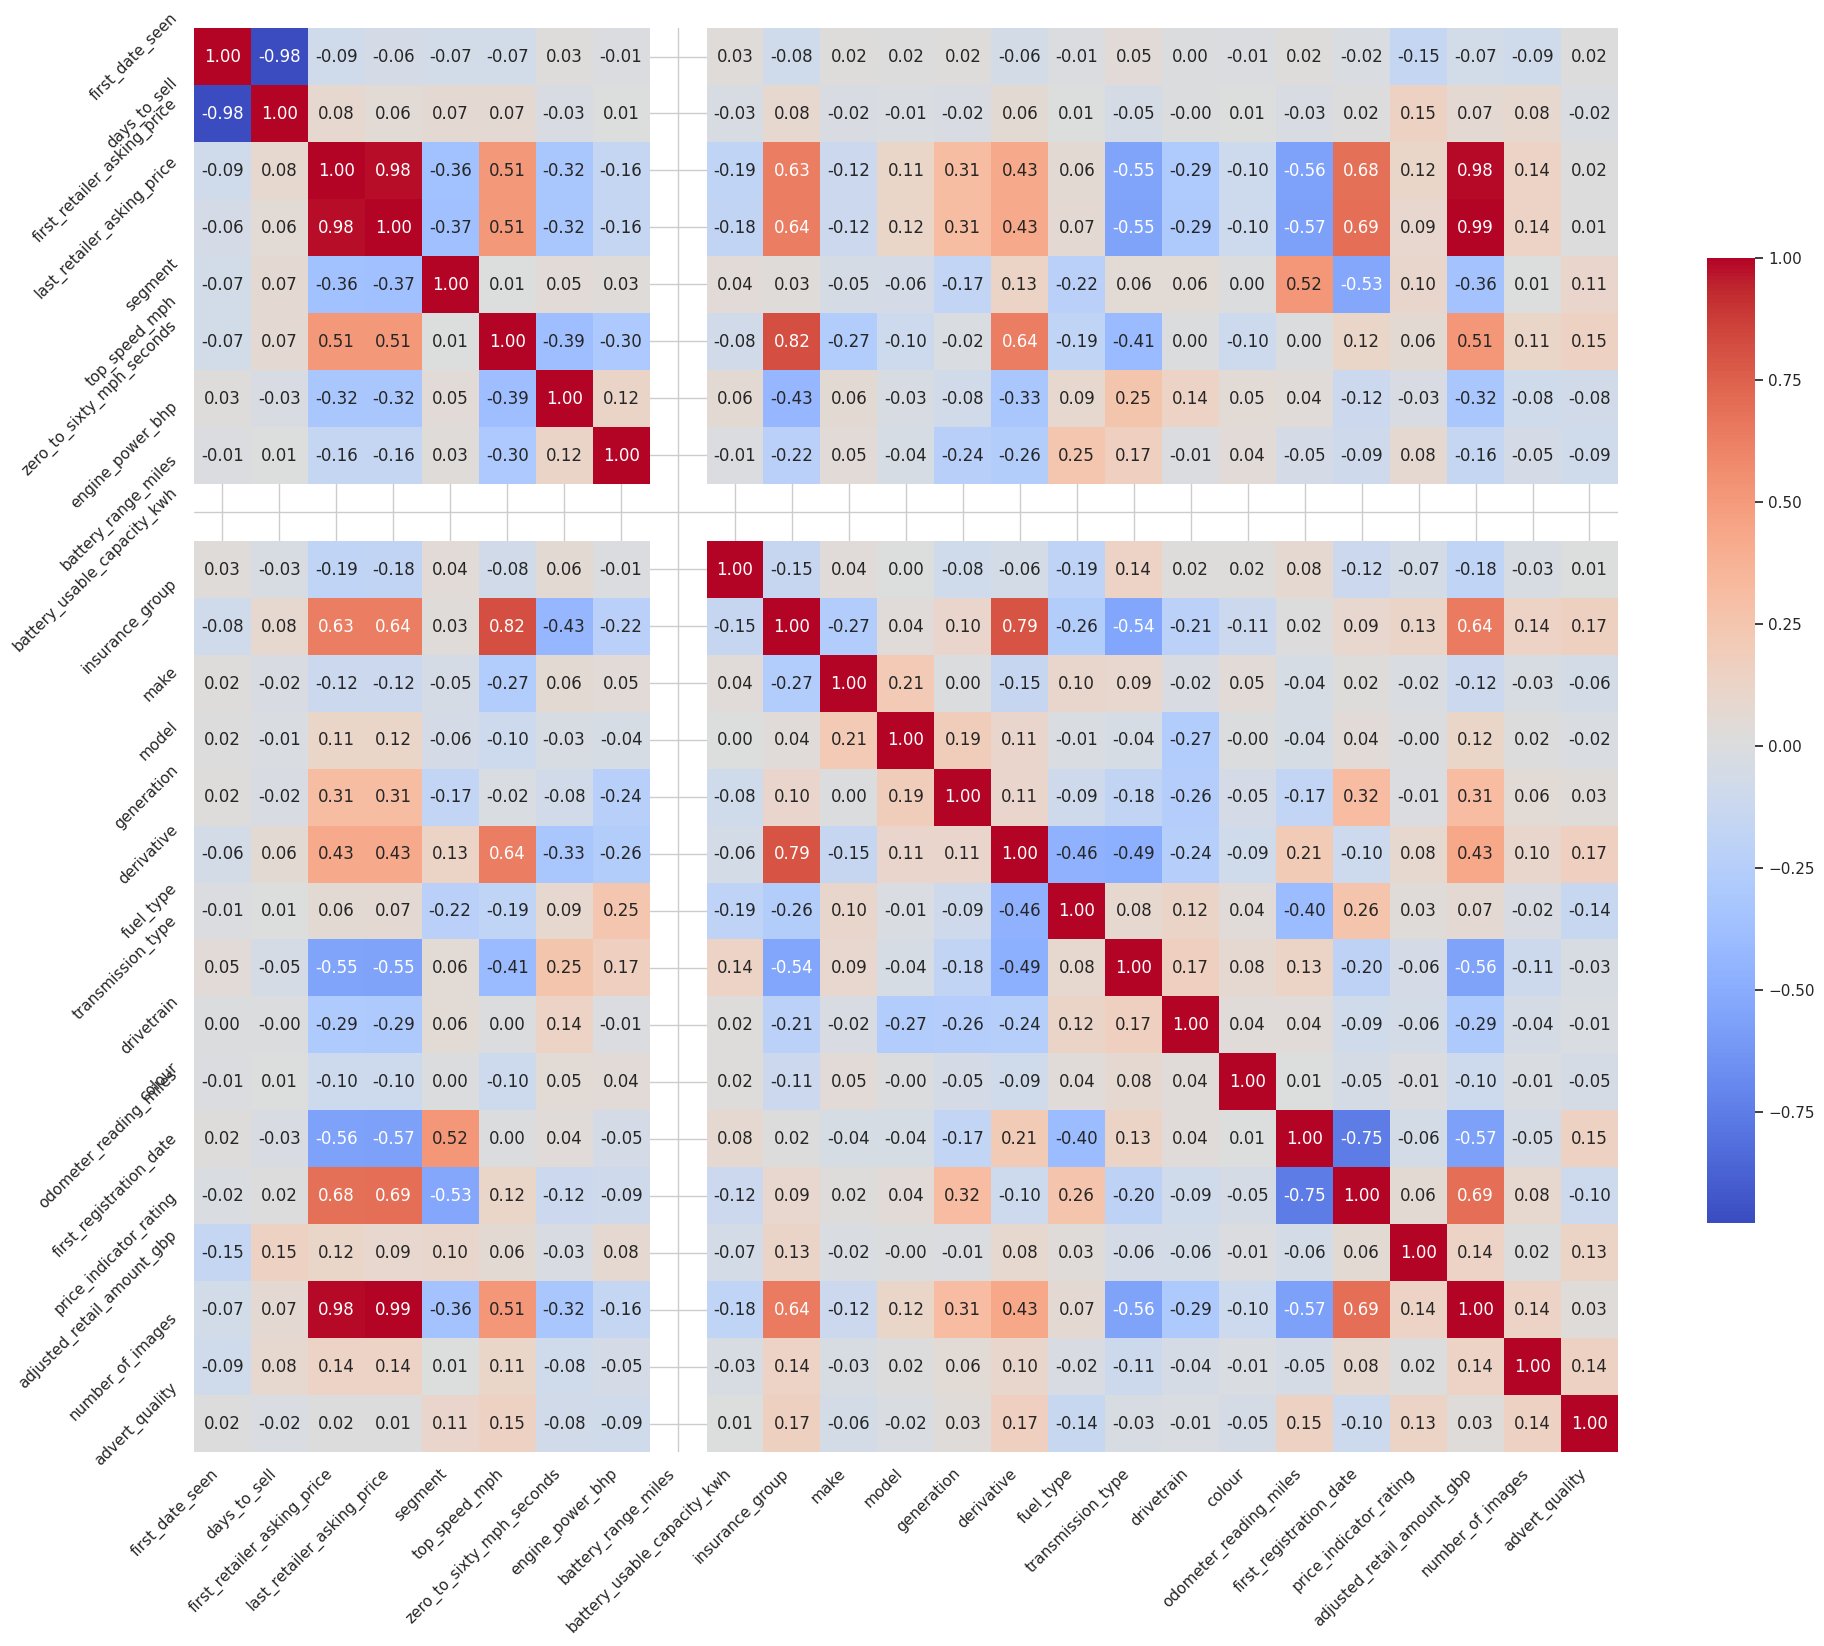

In [261]:
correlation_matrix = df.corr()
plt.figure(figsize=(20, 20))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [264]:
features_to_drop=['colour','drivetrain','fuel_type','battery_range_miles','battery_usable_capacity_kwh','segment']
df = df.drop(features_to_drop, axis=1)

In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202630 entries, 1 to 224554
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   first_date_seen              202630 non-null  int64  
 1   days_to_sell                 202630 non-null  int32  
 2   first_retailer_asking_price  202630 non-null  float64
 3   last_retailer_asking_price   202630 non-null  float64
 4   top_speed_mph                202630 non-null  float64
 5   zero_to_sixty_mph_seconds    202630 non-null  int64  
 6   engine_power_bhp             202630 non-null  int64  
 7   insurance_group              202630 non-null  int64  
 8   make                         202630 non-null  int64  
 9   model                        202630 non-null  int64  
 10  generation                   202630 non-null  int64  
 11  derivative                   202630 non-null  int64  
 12  transmission_type            202630 non-null  int64  
 13 

In [266]:
from sklearn.model_selection import train_test_split


In [267]:
X = df.drop(columns=['days_to_sell'])
y = df['days_to_sell']

In [268]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0,
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((151972, 18), (151972,), (50658, 18), (50658,))

In [269]:
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [270]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize the KNN Regressor
knn = KNeighborsRegressor(n_neighbors=7)  # n_neighbors can be tuned

# Fit the model on the training data
knn.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = knn.predict(X_test_scaled)

In [271]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("R^2 Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R^2 Score: 0.9100724902698001
Mean Absolute Error: 12.032241417234902
Mean Squared Error: 270.389840716578


In [273]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [2, 3, 4,5, 6, 7, 10, 12, 15, 20],
              'weights': ['uniform','distance']}

knn_cv = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5)
knn_cv.fit(X_train_scaled, y_train)

print("Best Parameters:", knn_cv.best_params_)
print("Best Score:", knn_cv.best_score_)

Best Parameters: {'n_neighbors': 7, 'weights': 'distance'}
Best Score: 0.902782806791903
